In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from decimal import Decimal, ROUND_DOWN


### Caracterización del discriminador

In [304]:
amplitud_mV = [40, 30, 20, 50, 10, 15, 25, 35]
V_the = [0.45, 0.36, 0.25, 0.54, 0.20, 0.21, 0.33, 0.43]

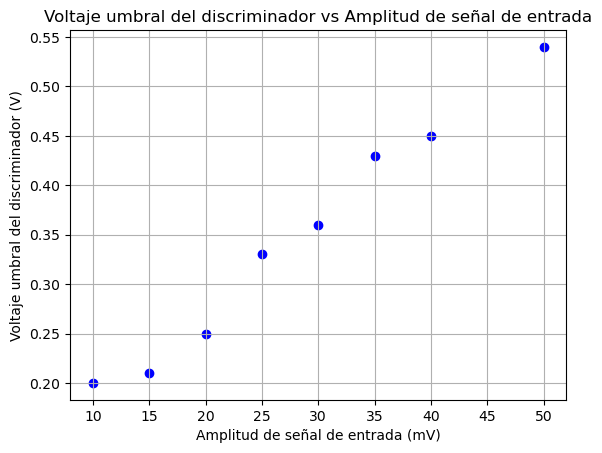

In [305]:
plt.scatter(amplitud_mV, V_the, color='blue')
plt.title('Voltaje umbral del discriminador vs Amplitud de señal de entrada')
plt.xlabel('Amplitud de señal de entrada (mV)')
plt.ylabel('Voltaje umbral del discriminador (V)')
plt.grid(True)
plt.savefig("Caracterización del discriminador.jpeg")

### Medición

In [307]:
data = pd.read_csv("muon_data.data", delimiter=' ', header = None)

In [267]:
times_decay = (data[0]. 
                astype(float).to_numpy())

In [268]:
times_decay = np.sort(times_decay[times_decay <= 20000])
print(f"Número de partículas que decayerón: {len(times_decay)}")

Número de partículas que decayerón: 9454


In [269]:
max_tiempo = np.max(times_decay)
bins = np.linspace(0, max_tiempo, 21)
frequency, _ = np.histogram(times_decay, bins=bins)

In [270]:
time_decay = (bins[:-1] + bins[1:]) / 2

In [271]:
cumulative_frequencies = np.cumsum(frequency)

In [272]:
remaining_particles = np.zeros_like(cumulative_frequencies)  
remaining_particles[0] = len(times_decay) - cumulative_frequencies[0]
for i in range(1, len(cumulative_frequencies)):
    remaining_particles[i] = remaining_particles[i-1] - cumulative_frequencies[i]

In [306]:
data = pd.DataFrame({
    "Time Decay": time_decay,
    "Frecuencia": frequency,
    "Suma acumulada": cumulative_frequencies,
    "Remaining Particles": remaining_particles
})
data

,Time Decay,Frecuencia,Suma acumulada,Remaining Particles
0,497.0,3283,3283,6171
1,1491.0,2252,5535,636
2,2485.0,1387,6922,-6286
3,3479.0,846,7768,-14054
4,4473.0,553,8321,-22375
5,5467.0,374,8695,-31070
6,6461.0,210,8905,-39975
7,7455.0,157,9062,-49037
8,8449.0,94,9156,-58193
9,9443.0,68,9224,-67417


### Primer ajuste

In [274]:
def decay_model(t, A, tau, B):
    return A * np.exp(-t / tau) + B

t_data = time_decay[frequency>0]
N_data = frequency[frequency>0]

params, cov = curve_fit(decay_model, t_data, N_data, p0=[8, 2200, 0])

In [276]:
A_fit, tau_fit, B_fit = params
y_trend = decay_model(t_data, *params)
residuals=N_data-y_trend
normalised_residuals=residuals/np.std(residuals)
errors = np.sqrt(frequency)
errors = np.sqrt(N_data)


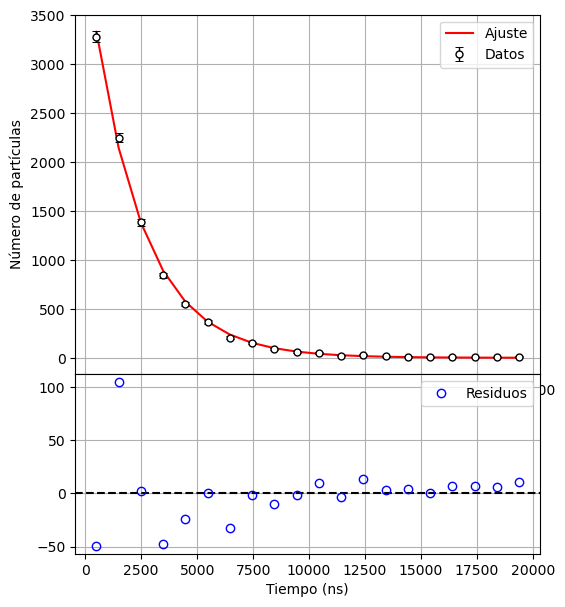

In [277]:
fig, axs = plt.subplots(2,1, sharex=False,figsize=(6,7), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)

axs[0].plot(t_data, y_trend, ls="-", c="r", label ="Ajuste")
axs[0].errorbar(t_data, N_data, fmt="o", ecolor="k", yerr = errors, elinewidth=1., capsize=3,    
    capthick=0.7, markerfacecolor='white', markeredgecolor='k', markersize=5, linestyle='None', label="Datos")
axs[0].set_ylabel('Número de partículas')
axs[0].legend(loc=0)
axs[0].grid("major")
axs[0].legend()

axs[1].axhline(y=0,color='k',linestyle='--')
axs[1].plot(t_data, residuals, linestyle='None', marker='o', markerfacecolor='none', markeredgecolor='b', label='Residuos')
axs[1].grid("major")
axs[1].set_xlabel('Tiempo (ns)')
axs[1].legend()

plt.savefig("Primer ajuste.jpeg")

In [278]:
## Gf/(hc^3)-> Constante de fermi 
hbar = 6.582119569e-25 *1e9     # GeV·ns
m_mu = 0.1056583745        # GeV
tau_mu = tau_fit     # s
numerador = 192 * np.pi**3 * hbar  
denominador = (m_mu)**5 * tau_mu  
rhs = np.sqrt(numerador / denominador)
rhs

np.float64(1.148134016574515e-05)

In [279]:
## Incertidumbre
sigma_tau_mu = np.sqrt(np.diagonal(cov)[1])
sigma_Gf_hc= 1/2 * rhs* (sigma_tau_mu/tau_mu)
sigma_Gf_hc

np.float64(1.0578037869011503e-07)

### Segundo Ajuste

In [280]:
def decay_model(t, N0, tau):
    return N0 * np.exp(-t / tau) 

t_data = time_decay[frequency > 0]
N_data = frequency[frequency > 0]

params, cov = curve_fit(decay_model, t_data, N_data, p0=[10, 2000])
cov

array([[ 2027.12664339, -1141.4204196 ],
       [-1141.4204196 ,  1176.41092572]])

In [281]:
N0_fit, tau_fit = params
y_trend = decay_model(t_data, *params)
residuals=N_data-y_trend
normalised_residuals=residuals/np.std(residuals)
errors = np.sqrt(frequency)

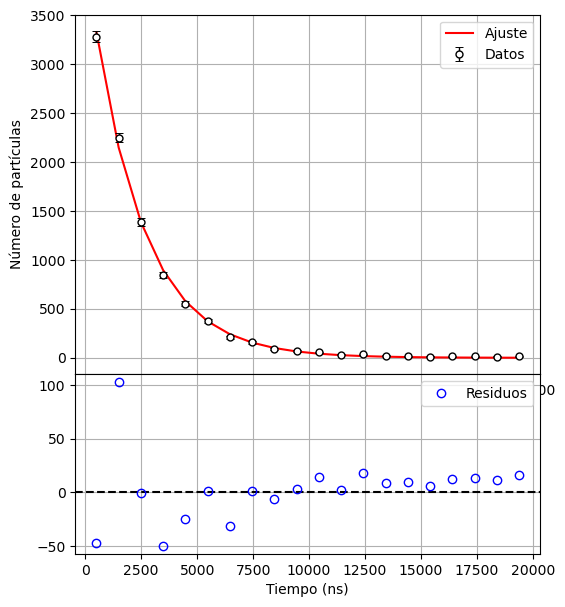

In [282]:
fig, axs = plt.subplots(2,1, sharex=False,figsize=(6,7), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)

axs[0].plot(t_data, y_trend, ls="-", c="r", label ="Ajuste")
axs[0].errorbar(t_data, N_data, fmt="o", ecolor="k", yerr = errors, elinewidth=1., capsize=3,    
    capthick=0.7, markerfacecolor='white', markeredgecolor='k', markersize=5, linestyle='None', label="Datos")
axs[0].set_ylabel('Número de partículas')
axs[0].legend(loc=0)
axs[0].grid("major")
axs[0].legend()

axs[1].axhline(y=0,color='k',linestyle='--')
axs[1].plot(t_data, residuals, linestyle='None', marker='o', markerfacecolor='none', markeredgecolor='b', label='Residuos')
axs[1].grid("major")
axs[1].set_xlabel('Tiempo (ns)')
axs[1].legend()

plt.savefig("Segundo ajuste ajuste.jpeg")

In [283]:
## Ajuste lineal 
y = np.log(N_data
          )
sigma_N = errors
sigma_N0 = np.sqrt(np.diagonal(cov)[0])
x = t_data
error_y = 1/N_data*errors

In [284]:
coefficients,cov=np.polyfit(x, y, 1,cov=True, w=N_data)
poly = np.poly1d(coefficients)

y_trend = poly(x)
r2=r2_score(y,poly(x))

residuales=y-y_trend
residuales_normalizados=residuales/np.std(residuales)


m, b = coefficients[0], coefficients[1]
sigma_m, sigma_b = np.sqrt(cov[0,0]), np.sqrt(cov[1,1])

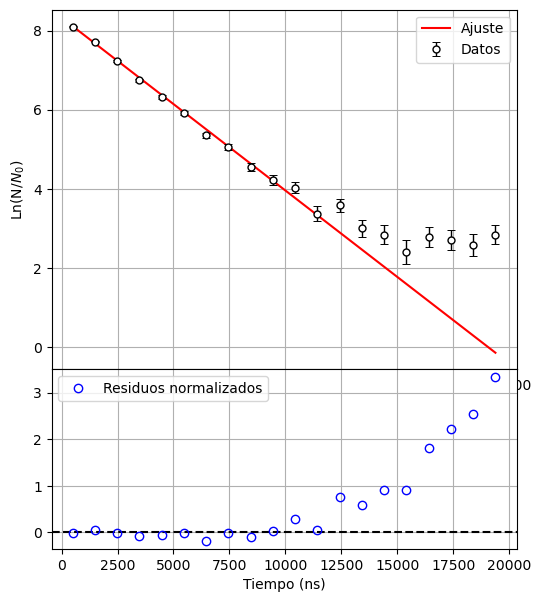

In [285]:
fig, axs = plt.subplots(2,1, sharex=False,figsize=(6,7), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)

axs[0].plot(x, y_trend, ls="-", c="r", label ="Ajuste")
axs[0].errorbar(x, y, fmt="o", ecolor="k", yerr = error_y, elinewidth=1., capsize=3,    
    capthick=0.7, markerfacecolor='white', markeredgecolor='k', markersize=5, linestyle='None', label="Datos")
axs[0].set_ylabel('Ln(N/$N_0$)')
axs[0].legend(loc=0)
axs[0].grid("major")
axs[0].legend()

axs[1].axhline(y=0,color='k',linestyle='--')
axs[1].plot(x, residuales_normalizados, linestyle='None', marker='o', markerfacecolor='none', markeredgecolor='b', label='Residuos normalizados')
axs[1].grid("major")
axs[1].set_xlabel('Tiempo (ns)')
axs[1].legend()

plt.savefig("Ajuste lineal.jpeg")

In [289]:
tau_obs = abs(1/m)
sigma_tau_obs = abs((tau_obs/m) * sigma_m)
tau_obs*1e-9, sigma_tau_obs*1e-9

(np.float64(2.2871182992289387e-06), np.float64(3.985344647018817e-08))